# Market Basket Analysis For Groceries Store

Market basket analysis is a powerful technique used to identify associations between products. It involves analyzing transactional data that contains lists of items purchased by customers to determine which groups of products are commonly purchased together. This technique provides valuable insights into customer preferences, allowing businesses to tailor their marketing strategies, product placement, cross-selling, and more to better meet the needs of their customers.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.frequent_patterns import fpgrowth
from collections import Counter
import networkx as nx

## Data

For our analysis, we will be utilizing transactional data from a grocery store between 2014-2015, that has been obtained from Kaggle. The dataset can be accessed at https://www.kaggle.com/datasets/rashikrahmanpritom/groceries-dataset-for-market-basket-analysismba and includes the following metadata:

1. _member_number_: A unique identification number for each customer
2. _Date_: The date on which the transaction occurred
3. _itemDescription_: A description of the purchased product
4. _year_: The year in which the transaction took place
5. _month_: The month in which the transaction took place
6. _day_: The day of the transaction
7. _day_of_week_: The day of the week on which the transaction took place.

In [2]:
df_invoice = pd.read_csv('groceries.csv')

In [3]:
df_invoice.head(10)

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,1808,2015-07-21,tropical fruit,2015,7,21,1
1,2552,2015-05-01,whole milk,2015,5,1,4
2,2300,2015-09-19,pip fruit,2015,9,19,5
3,1187,2015-12-12,other vegetables,2015,12,12,5
4,3037,2015-01-02,whole milk,2015,1,2,4
5,4941,2015-02-14,rolls/buns,2015,2,14,5
6,4501,2015-08-05,other vegetables,2015,8,5,2
7,3803,2015-12-23,pot plants,2015,12,23,2
8,2762,2015-03-20,whole milk,2015,3,20,4
9,4119,2015-12-02,tropical fruit,2015,12,2,2


## Data Transformation

For data transformation, the following steps were taken:
1. The Member_number column was converted from integer to string data type.
2. The Date column was converted into a datetime data type.
3. The data has no Transaction identification number so we assign index number to each row

In [4]:
df_invoice['Member_number'] = df_invoice['Member_number'].astype(str)
df_invoice['Date'] = pd.to_datetime(df_invoice['Date'])
df_invoice = df_invoice.reset_index().rename(columns={'index':'transaction_num'})

In [5]:
df_invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   transaction_num  38765 non-null  int64         
 1   Member_number    38765 non-null  object        
 2   Date             38765 non-null  datetime64[ns]
 3   itemDescription  38765 non-null  object        
 4   year             38765 non-null  int64         
 5   month            38765 non-null  int64         
 6   day              38765 non-null  int64         
 7   day_of_week      38765 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 2.4+ MB


In [6]:
df_invoice

,transaction_num,Member_number,Date,itemDescription,year,month,day,day_of_week
0,0,1808,2015-07-21,tropical fruit,2015,7,21,1
1,1,2552,2015-05-01,whole milk,2015,5,1,4
2,2,2300,2015-09-19,pip fruit,2015,9,19,5
3,3,1187,2015-12-12,other vegetables,2015,12,12,5
4,4,3037,2015-01-02,whole milk,2015,1,2,4
...,...,...,...,...,...,...,...,...
38760,38760,4471,2014-08-10,sliced cheese,2014,8,10,6
38761,38761,2022,2014-02-23,candy,2014,2,23,6
38762,38762,1097,2014-04-16,cake bar,2014,4,16,2
38763,38763,1510,2014-03-12,fruit/vegetable juice,2014,3,12,2


## Exploratory Data Analysis

Before delving into the market basket analysis, we will conduct some exploratory data analysis to gain insights into the data.

In [7]:
print(f"Customer counts: {df_invoice['Member_number'].nunique()}")
print(f"Item counts: {df_invoice['itemDescription'].nunique()}")

Customer counts: 3898
Item counts: 167


**Transaction Count by year**

Text(0.5, 0, 'year')

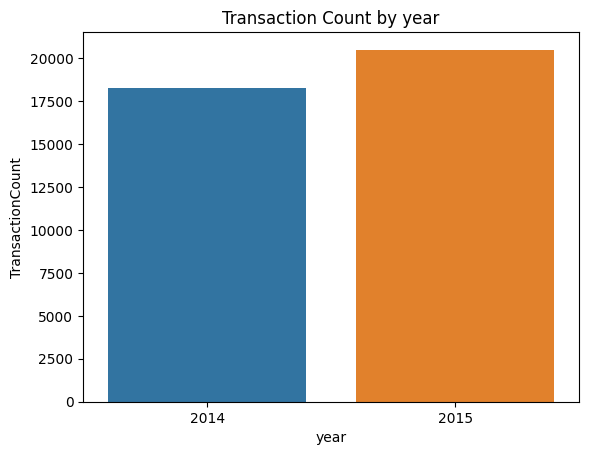

In [8]:
df_month_year = df_invoice.groupby('year').agg(TransactionCount = ('transaction_num', 'count'))
sns.barplot(x=df_month_year.index, y='TransactionCount', data=df_month_year)
plt.title('Transaction Count by year')
plt.xlabel('year')

**Transaction count by month**

(0.0, 2000.0)

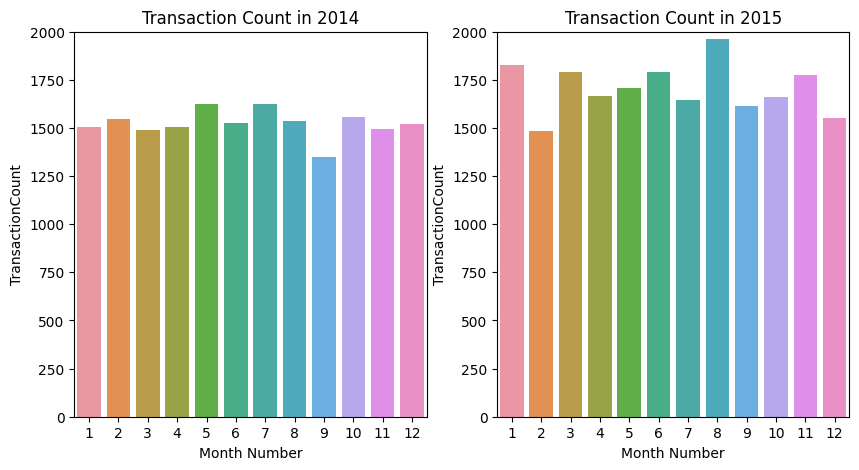

In [9]:
df_month_2014 = df_invoice[df_invoice['year'] == 2014].groupby('month').agg(TransactionCount = ('transaction_num', 'count'))
df_month_2015 = df_invoice[df_invoice['year'] == 2015].groupby('month').agg(TransactionCount = ('transaction_num', 'count'))

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.barplot(x=df_month_2014.index, y='TransactionCount', data=df_month_2014)
plt.title('Transaction Count in 2014')
plt.xlabel('Month Number')
plt.ylim(0,2000)

plt.subplot(1,2,2)
sns.barplot(x=df_month_2015.index, y='TransactionCount', data=df_month_2015)
plt.title('Transaction Count in 2015')
plt.xlabel('Month Number')
plt.ylim(0,2000)

**Transaction by weekday**

Text(0.5, 0, 'day')

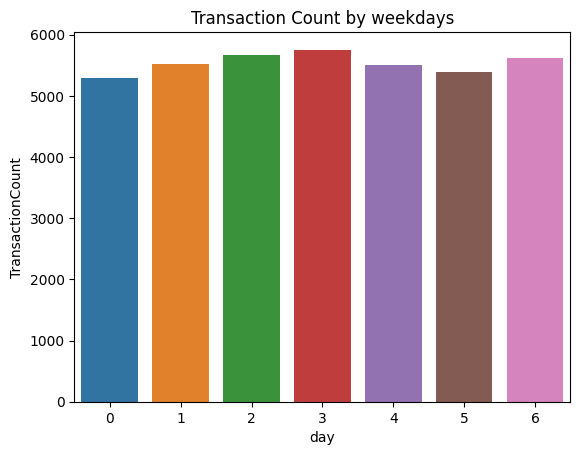

In [10]:
df_dow = df_invoice.groupby('day_of_week').agg(TransactionCount = ('transaction_num', 'count'))
sns.barplot(x=df_dow.index, y='TransactionCount', data=df_dow)
plt.title('Transaction Count by weekdays')
plt.xlabel('day')

**Distribution of basket size**

In [11]:
df_basket = pd.DataFrame(df_invoice.groupby('Member_number')['itemDescription'].agg(list))
df_basket['itemDescription'] = df_basket['itemDescription'].apply(lambda x: set(x))
df_basket['itemCount']  = df_basket['itemDescription'].apply(lambda x: len(x))

<AxesSubplot: >

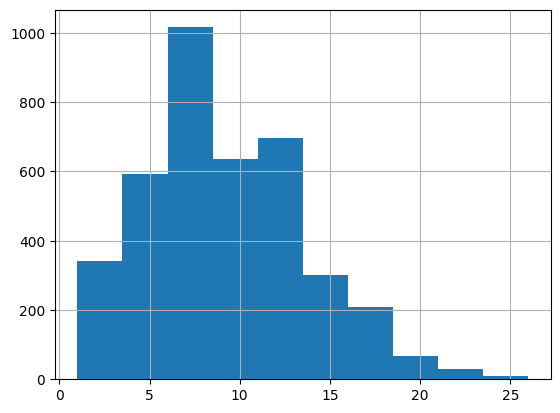

In [12]:
df_basket['itemCount'].hist()

In [13]:
itemlist = df_basket['itemDescription'].tolist()
flatitem = [item for sublist in itemlist for item in sublist]
counter = Counter(flatitem)
df_itemcount = pd.DataFrame(counter.most_common(50), columns=['Product', 'Count'])

**Most purchased item**

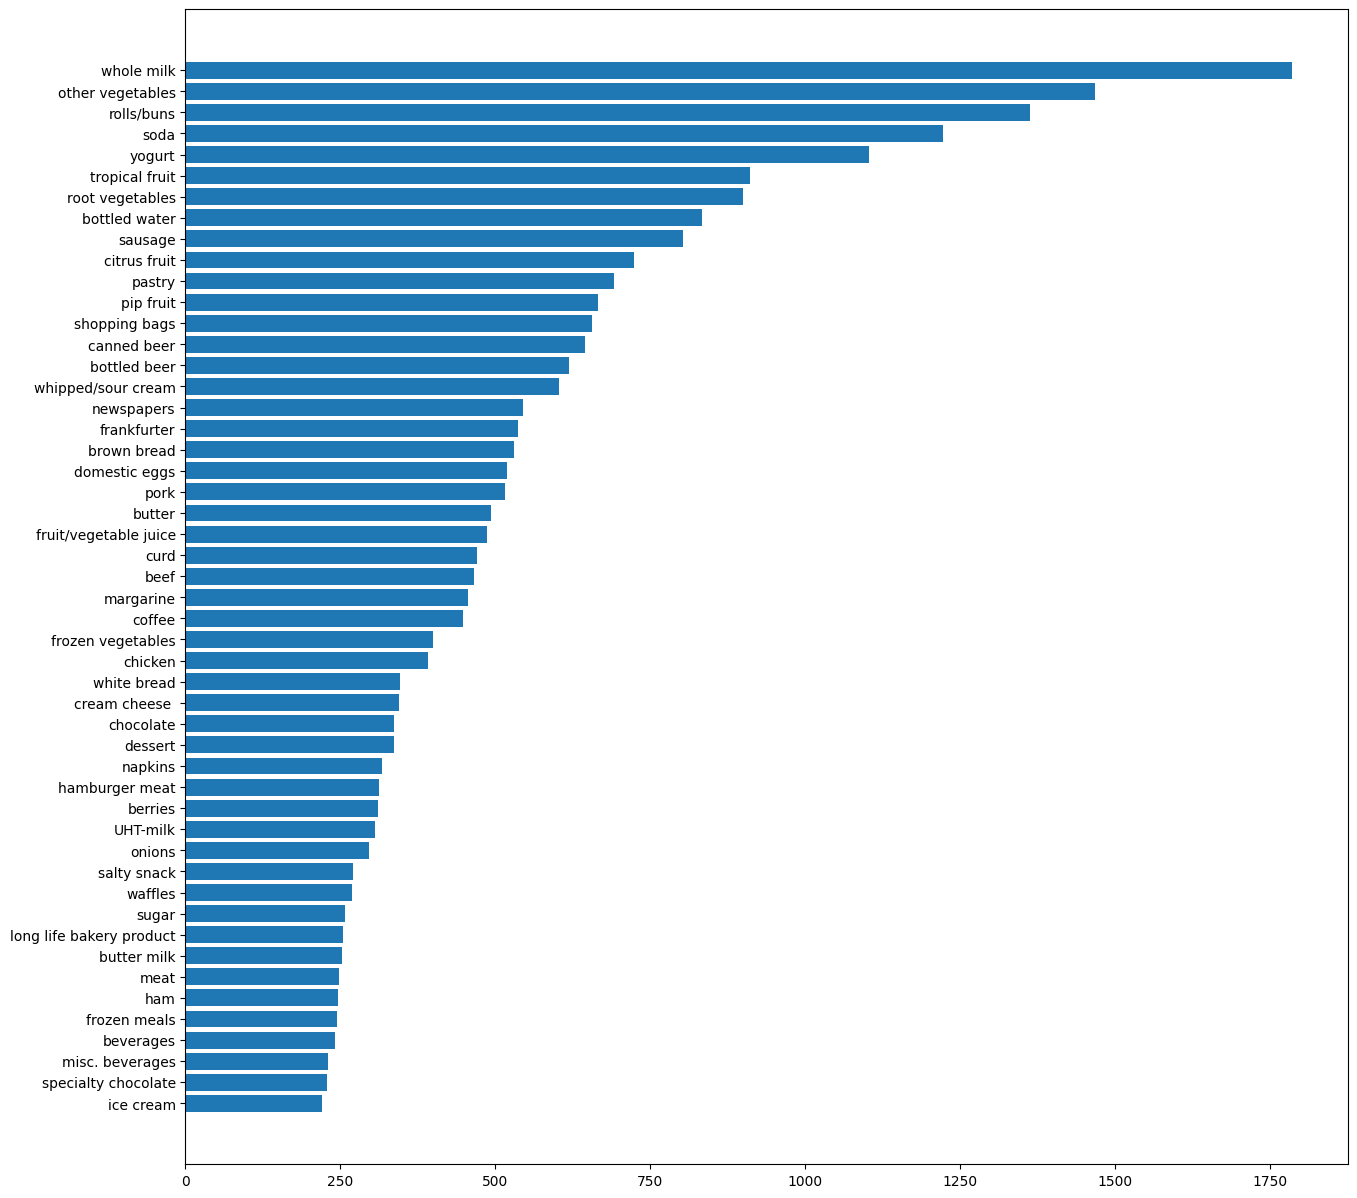

In [14]:
plt.figure(figsize=(15,15))
plt.barh(y='Product', width='Count', data=df_itemcount)
plt.gca().invert_yaxis()

## Market Basket Analysis

Market basket analysis involves analyzing transactional data to identify the co-occurrence of items in a customer's basket
In simple term it often represented as **association rules** between items, where an **antecedent** represents a condition or pattern and a **consequent** represents an outcome or conclusion. 

For instance, if a customer buys **bread (antecedent)**, then they are likely to buy **milk (consequent)**

**Common statistical metrics used in market basket analysis include**
- **Support**
	- Measures the frequency of occurrence of a given itemset in the transactional data.
	- Higher supports means the item(s) are frequently appear in the transaction
- **Confidence**
	- Measures the conditional probability of one item being purchased given that another item is already in the basket.
	- Confidence ranges from 0 to 1, with higher values indicating stronger relationships between items.
- **Lift**
	- Which measures the strength of association between two items.
	- Lift values greater than 1 indicates a positive association, meaning that the presence of one item in a basket makes it more likely that the other item will also be in the basket and vice versa
- **Leverage**
	- Which quantifies how much the occurrence of two items together deviates from what would be expected if they were independent.
	- The range of leverage is from -1 to 1, with a value greater than 0 indicating a significant non-random relationship between the items in a basket.
- **Conviction**
	- which measures how much the antecedent of a rule implies the consequent.
	- The range of conviction is from 0 to infinity, with a value greater than 1 indicating that the antecedent and consequent are positively related and a value closer to 0 indicating that they are not related or negatively related.

To prepare the data for basket analysis, the following steps were taken:
1. The data was grouped by Member_number, and the products that each customer has purchased were aggregated into a list format.
2. The grouped data was then converted into a one-hot data table where each row represents a transaction, each column represents an item, and the value is a Boolean indicating whether the item was purchased in that transaction or not

In [15]:
encoder = TransactionEncoder().fit(itemlist)
onehot = encoder.transform(itemlist)
onehot = pd.DataFrame(onehot, columns = encoder.columns_)
onehot.iloc[:,:5].head(10)

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
5,False,False,False,False,False
6,False,False,False,False,False
7,False,False,False,False,False
8,False,False,False,False,False
9,False,True,False,False,False


**Association Rule Mining**

One commonly used algorithm to get association rules is the **Apriori algorithm**, which initially generates frequent itemsets and uses them to derive association rules. Think of it as a first filtering line for gettting a most common itemsets. Once we have identified the frequent itemsets using the Apriori algorithm, we can calculate different metrics such as support, confidence, and lift to derive association rules from the frequent itemsets.

In [16]:
df_apiori = apriori(onehot, min_support=0.01, max_len=2, use_colnames = True).sort_values('support', ascending=False)

In [17]:
df_apiori

,support,itemsets
113,0.458184,(whole milk)
69,0.376603,(other vegetables)
84,0.349666,(rolls/buns)
94,0.313494,(soda)
114,0.282966,(yogurt)
...,...,...
414,0.010005,"(frankfurter, butter milk)"
705,0.010005,"(dog food, whole milk)"
882,0.010005,"(newspapers, hygiene articles)"
1106,0.010005,"(pork, waffles)"


In [18]:
df_assoc_rules = association_rules(df_apiori, metric = "support", min_threshold=0)

The association rule table should look like this

In [19]:
df_assoc_rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(other vegetables),(whole milk),0.376603,0.458184,0.191380,0.508174,1.109106,0.018827,1.101643
1,(whole milk),(other vegetables),0.458184,0.376603,0.191380,0.417693,1.109106,0.018827,1.070564
2,(rolls/buns),(whole milk),0.349666,0.458184,0.178553,0.510638,1.114484,0.018342,1.107190
3,(whole milk),(rolls/buns),0.458184,0.349666,0.178553,0.389698,1.114484,0.018342,1.065592
4,(soda),(whole milk),0.313494,0.458184,0.151103,0.481997,1.051973,0.007465,1.045971
5,(whole milk),(soda),0.458184,0.313494,0.151103,0.329787,1.051973,0.007465,1.024310
6,(yogurt),(whole milk),0.282966,0.458184,0.150590,0.532185,1.161510,0.020940,1.158185
7,(whole milk),(yogurt),0.458184,0.282966,0.150590,0.328667,1.161510,0.020940,1.068076
8,(other vegetables),(rolls/buns),0.376603,0.349666,0.146742,0.389646,1.114335,0.015056,1.065502
9,(rolls/buns),(other vegetables),0.349666,0.376603,0.146742,0.419663,1.114335,0.015056,1.074197


## **Visualizing rules**

<AxesSubplot: xlabel='support', ylabel='confidence'>

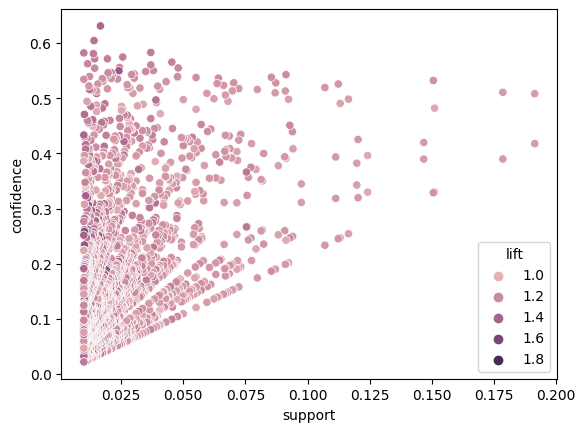

In [20]:
#support-confience border
sns.scatterplot(x='support', y='confidence', data=df_assoc_rules, hue='lift')

_According to R. J. Bayardo Jr. and R. Agrawal in a research paper titled "Mining the Most Interesting Rules" in 1999_, Rules that lie above the border have high confidence but low support, which means that they are rare but highly predictive. On the other hand, rules that lie below the border have high support but low confidence, which means that they are common but less predictive. The rules that lie close to the border have both high support and high confidence (top right), and are generally the most interesting and useful rules for insights and predictions.

<AxesSubplot: xlabel='antecedent support', ylabel='consequent support'>

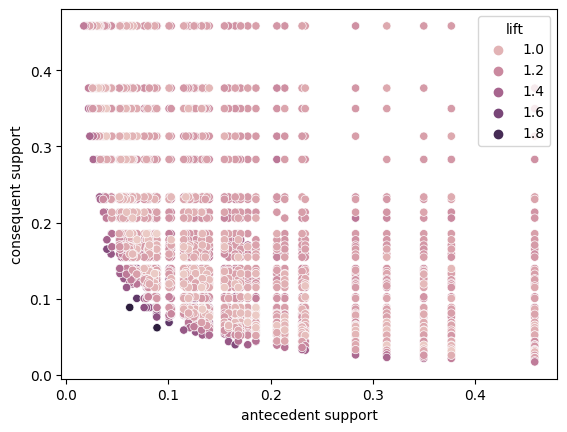

In [21]:
#items support scatterplot
sns.scatterplot(x='antecedent support', y='consequent support', data=df_assoc_rules, hue='lift')

The threshold for the antecedent-consequent support value typically ranges between 0 and 0.5 in association rule mining. I have observed that rules with high lift values often have low consequent-antecedent support, which may indicate that the rule is based on a smaller number of records. Therefore, rules with the highest lift values may not be as informative as expected.

It is important to consider the balance between lift value and support when evaluating the usefulness of a rule. While high lift values indicate strong association between the antecedent and consequent, low support values suggest that the rule may not be supported by a sufficient number of records. Therefore, it is recommended to examine the support and lift values together when selecting rules for further analysis, rather than relying solely on the lift value.

## **Creating a Business Scenario**

To gain more insights from our analysis, we will define a business problem to establish the scope of our analysis. 

Specifically, **the store manager is interested in understanding what other items are frequently purchase with rolls/buns**, in order to develop an effective marketing strategy to increase the sales of the product.

In [102]:
#analyzing what people usually buy with rolls/buns, "Customer who bought X also bought rolls/buns"
df_rules_spec = df_assoc_rules[df_assoc_rules['consequents'].apply(lambda x: 'rolls/buns' in x)]

In [23]:
df_rules_spec.head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3,(whole milk),(rolls/buns),0.458184,0.349666,0.178553,0.389698,1.114484,0.018342,1.065592
8,(other vegetables),(rolls/buns),0.376603,0.349666,0.146742,0.389646,1.114335,0.015056,1.065502
15,(soda),(rolls/buns),0.313494,0.349666,0.119805,0.382160,1.092928,0.010187,1.052593
22,(yogurt),(rolls/buns),0.282966,0.349666,0.111339,0.393472,1.125279,0.012396,1.072224
43,(root vegetables),(rolls/buns),0.230631,0.349666,0.090816,0.393771,1.126133,0.010172,1.072752


The get the meaningful rules, I filter out a weak rules by the using the metric as follows:
1. _Support_ must be greater than the median support value of the entire dataset.
2. _Confidence_ must be greater than the median confidence value of the entire dataset.
3. _Lift_ must be greater than 1

In [24]:
df_rules_spec_pruned = df_rules_spec[(df_rules_spec['support'] >= df_rules_spec['support'].quantile(q=0.5)) &
                              (df_rules_spec['confidence'] >= df_rules_spec['confidence'].quantile(q=0.5)) &
                              (df_rules_spec['lift'] >= 1)
                             ].sort_values('support', ascending=False)

In [25]:
df_rules_spec_pruned['antecedents'] = df_rules_spec_pruned['antecedents'].apply(lambda x: ', '.join(x))
df_rules_spec_pruned['consequents'] = df_rules_spec_pruned['consequents'].apply(lambda x: ', '.join(x))
df_rules_spec_pruned.reset_index(drop=True, inplace=True)

In [26]:
df_rules_spec_pruned

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,sausage,rolls/buns,0.206003,0.349666,0.082350,0.399751,1.143235,0.010318,1.083439
1,shopping bags,rolls/buns,0.168291,0.349666,0.068753,0.408537,1.168361,0.009907,1.099533
2,canned beer,rolls/buns,0.165213,0.349666,0.066701,0.403727,1.154605,0.008931,1.090663
3,bottled beer,rolls/buns,0.158799,0.349666,0.063109,0.397415,1.136555,0.007582,1.079240
4,newspapers,rolls/buns,0.139815,0.349666,0.057209,0.409174,1.170184,0.008320,1.100720
5,frankfurter,rolls/buns,0.137506,0.349666,0.055156,0.401119,1.147149,0.007075,1.085915
6,fruit/vegetable juice,rolls/buns,0.124936,0.349666,0.053617,0.429158,1.227336,0.009931,1.139253
7,curd,rolls/buns,0.120831,0.349666,0.050026,0.414013,1.184022,0.007775,1.109808
8,chicken,rolls/buns,0.100564,0.349666,0.042329,0.420918,1.203771,0.007165,1.123043
9,frozen vegetables,rolls/buns,0.102617,0.349666,0.041047,0.400000,1.143947,0.005165,1.083889


**Identifying the best rule for item bought with 'Rolls/Buns'**

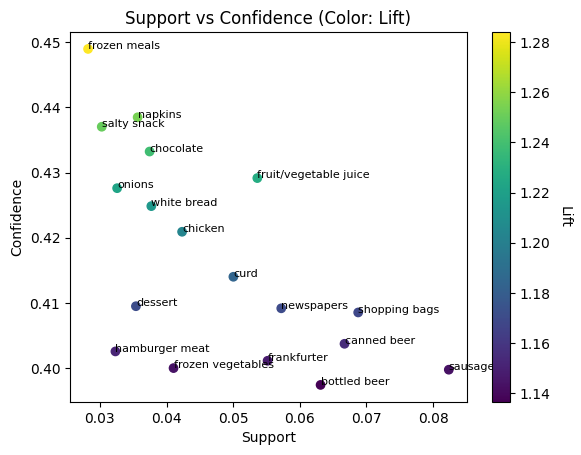

In [27]:
fig, ax = plt.subplots()
scatter = ax.scatter(df_rules_spec_pruned['support'], df_rules_spec_pruned['confidence'], c=df_rules_spec_pruned['lift'])
ax.set_xlabel('Support')
ax.set_ylabel('Confidence')
ax.set_title('Support vs Confidence (Color: Lift)')

for i, row in df_rules_spec_pruned.iterrows():
    ax.text(row['support'], row['confidence'], row['antecedents'], fontsize=8)


    
cbar = plt.colorbar(scatter, cmap='viridis')
cbar.ax.set_ylabel('Lift', rotation=270, labelpad=15)
plt.show()


/tmp/ipykernel_11413/3800935855.py:47: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



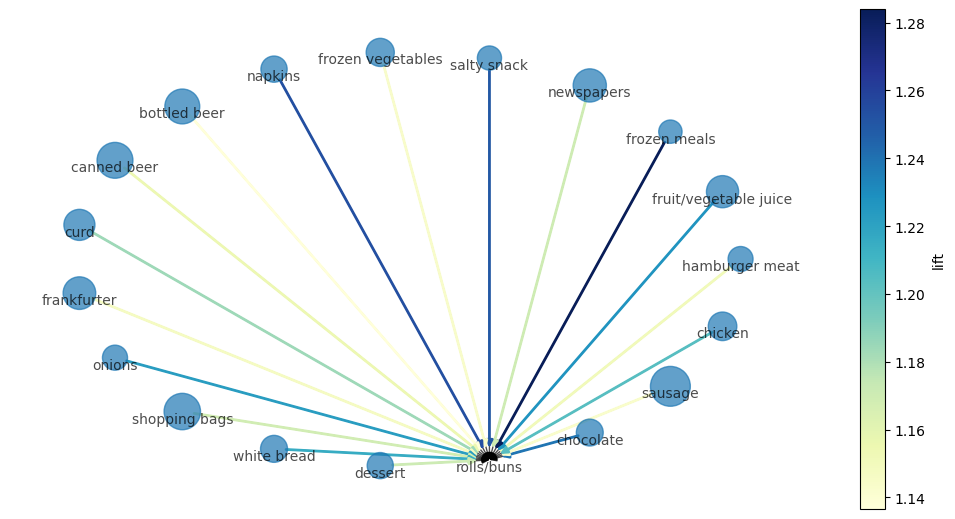

In [101]:
from matplotlib import cm
from matplotlib.colors import Normalize

plt.figure(figsize=(10,5))

# Create a directed graph
G = nx.DiGraph()
default_node_size = 0
# Add nodes to the graph
nodes = set(df_rules_spec_pruned['antecedents'].tolist() + df_rules_spec_pruned['consequents'].tolist())
for node in nodes:
    G.add_node(node)

# Add edges between antecedents and consequents
for index, row in df_rules_spec_pruned.iterrows():
    G.add_edge(row['antecedents'], row['consequents'])
    
edge_colors = dict(zip([row['antecedents'] for i, row in df_rules_spec_pruned.iterrows()], [row['lift'] for i, row in df_rules_spec_pruned.iterrows()]))

node_sizes = dict(zip([row['antecedents'] for i, row in df_rules_spec_pruned.iterrows()], [row['support'] for i, row in df_rules_spec_pruned.iterrows()]))

edge_labels = nx.get_edge_attributes(G,'lift')

#assign color to edge
norm = Normalize(vmin=df_rules_spec_pruned['lift'].min(), vmax = df_rules_spec_pruned['lift'].max())
mappable = cm.ScalarMappable(norm=norm, cmap='YlGnBu')
node_order = list(G.nodes)
new_edge_colors_order = {node: edge_colors[node] for node in node_order if node in edge_colors}

#plottting network
pos = nx.circular_layout(G)  # Define the layout
nx.draw(G,
        pos,
        with_labels=True,
        font_size=10,
        verticalalignment = 'top',
        node_size=[node_sizes.get(n, default_node_size) * 10000 for n in G.nodes()],
        alpha=0.7)  # Draw the graph

edges = nx.draw_networkx_edges(G,
                               pos,
                               edge_color=new_edge_colors_order.values(),
                               edge_cmap=plt.cm.YlGnBu,
                               width=2)


cbar = plt.colorbar(mappable, label='lift')
plt.show()

**Implications**

From the visualizations, I have observed that:
1. Rules: {sausage} -> {rolls/buns}, has the highest support values, suggests that sausage and rolls/buns are frequently purchased together.
2. Rules: {frozen meal} -> {rolls/buns}, has highest confidence, suggests that when customers buy frozen meals, they are highly likely to also buy rolls/buns.
3. Both rules has lift higher than 1, suggests that sausage and rolls/buns, as well as frozen meals and rolls/buns, are positively correlated and are more likely to appear together in transactions than expected by chance. 


**Remark:** it's important to note that correlation does not necessarily imply causation. Just because two items are frequently purchased together does not necessarily mean that one item causes the other to be purchased. Therefore, it's important to interpret the association rules with caution and to consider other factors that may influence customers' purchasing behaviors.

## Conclusion

In the overall analysis of the retail dataset, we can draw the following conclusions:
- The retail business experienced growth, evident in an increase in transaction count betweem 2014-2015.
- Wednesday has the most customer activity in term of transaction count
- On average, customers purchase 6-7 items per transaction, with whole milk being the most frequently bought item.

Regarding the analysis of rolls/buns, we can conclude that:
- Both sausage and frozen meals are positively correlated with rolls/buns, meaning they are more likely to appear together in transactions than expected by chance.
- These findings suggest that customers who buy items like sausages and frozen meals may be good target groups to marketize rolls/buns to.